### DS4200 Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
import geopandas as gpd
import folium

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
nba_df = pd.read_csv('all_seasons.csv', index_col = 0)
pd.set_option('display.max_columns', None)

nba_df.head()

player_name team_abbreviation   age  player_height  player_weight  \
0  Randy Livingston               HOU  22.0         193.04      94.800728   
1  Gaylon Nickerson               WAS  28.0         190.50      86.182480   
2      George Lynch               VAN  26.0         203.20     103.418976   
3    George McCloud               LAL  30.0         203.20     102.058200   
4      George Zidek               DEN  23.0         213.36     119.748288   

                 college country draft_year draft_round draft_number  gp  \
0        Louisiana State     USA       1996           2           42  64   
1  Northwestern Oklahoma     USA       1994           2           34   4   
2         North Carolina     USA       1993           1           12  41   
3          Florida State     USA       1989           1            7  64   
4                   UCLA     USA       1995           1           22  52   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

    season  
0  1996-97  
1  1996-97  
2  1996-97  
3  1996-97  
4  1996-97

#### Static Visualization #1

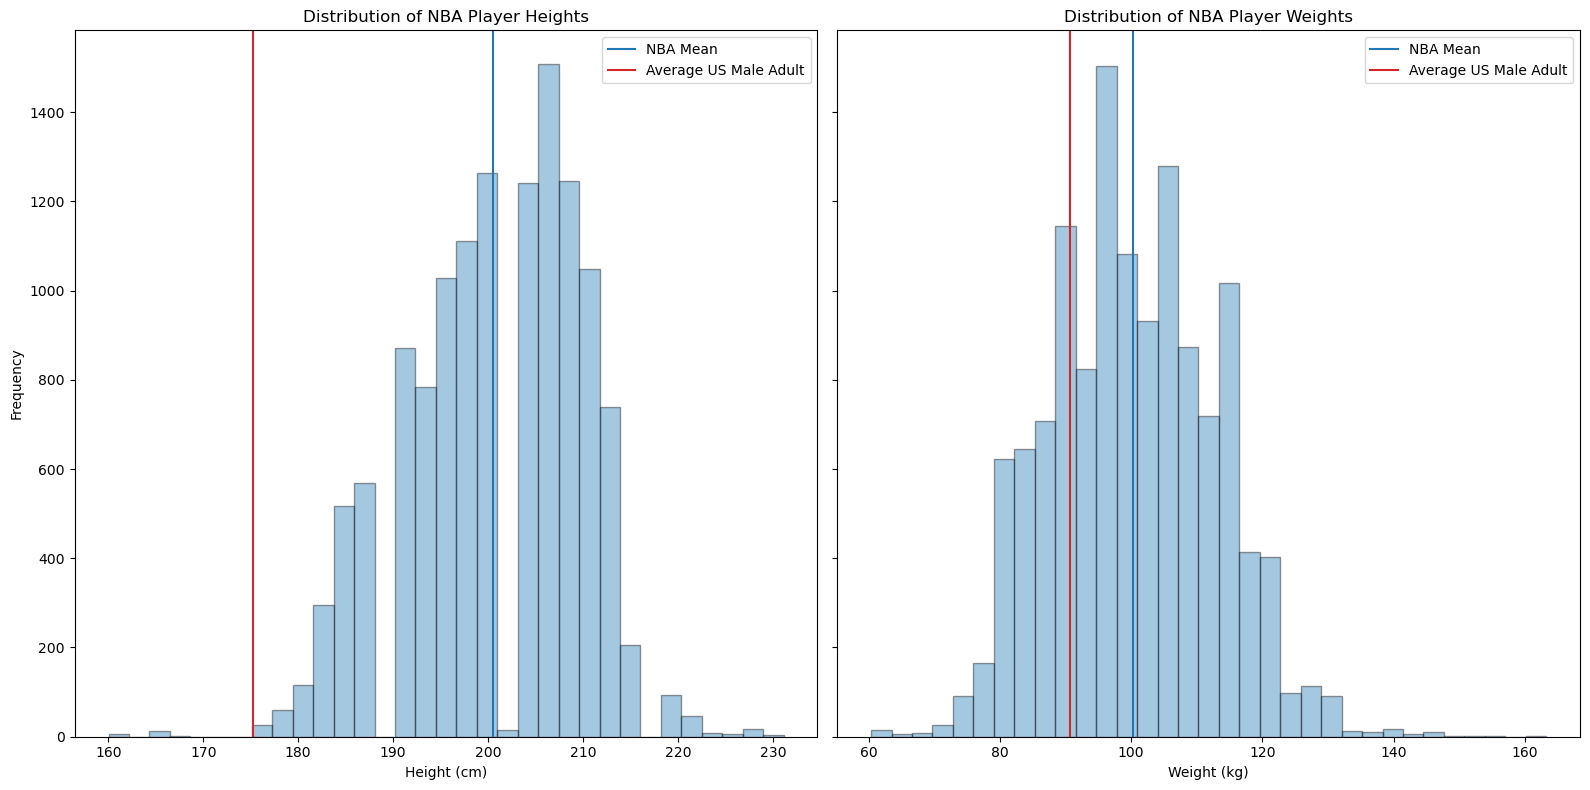

In [3]:
# https://www.cdc.gov/nchs/fastats/body-measurements.htm
average_us_male_h = 175.26
average_us_male_w = 90.63

nba_mean_h = nba_df['player_height'].mean()
nba_mean_w = nba_df['player_weight'].mean()

fig, ax = plt.subplots(1, 2, figsize = (16, 8), sharey = True)
plt.subplots_adjust(wspace = 0.05)

ax[0].hist(nba_df['player_height'], bins = 33, edgecolor = 'black', color = 'tab:blue', alpha = 0.4)
ax[1].hist(nba_df['player_weight'], bins = 33, edgecolor = 'black', color = 'tab:blue', alpha = 0.4)

ax[0].axvline(nba_mean_h, color = 'tab:blue', label = 'NBA Mean')
ax[1].axvline(nba_mean_w, color = 'tab:blue', label = 'NBA Mean')

ax[0].axvline(average_us_male_h, color = 'tab:red', label = 'Average US Male Adult')
ax[1].axvline(average_us_male_w, color = 'tab:red', label = 'Average US Male Adult')

ax[0].set_xlabel('Height (cm)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of NBA Player Heights')
ax[1].set_xlabel('Weight (kg)')
ax[1].set_title('Distribution of NBA Player Weights')

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

plt.tight_layout()
plt.show()

#### Static Visualization #2

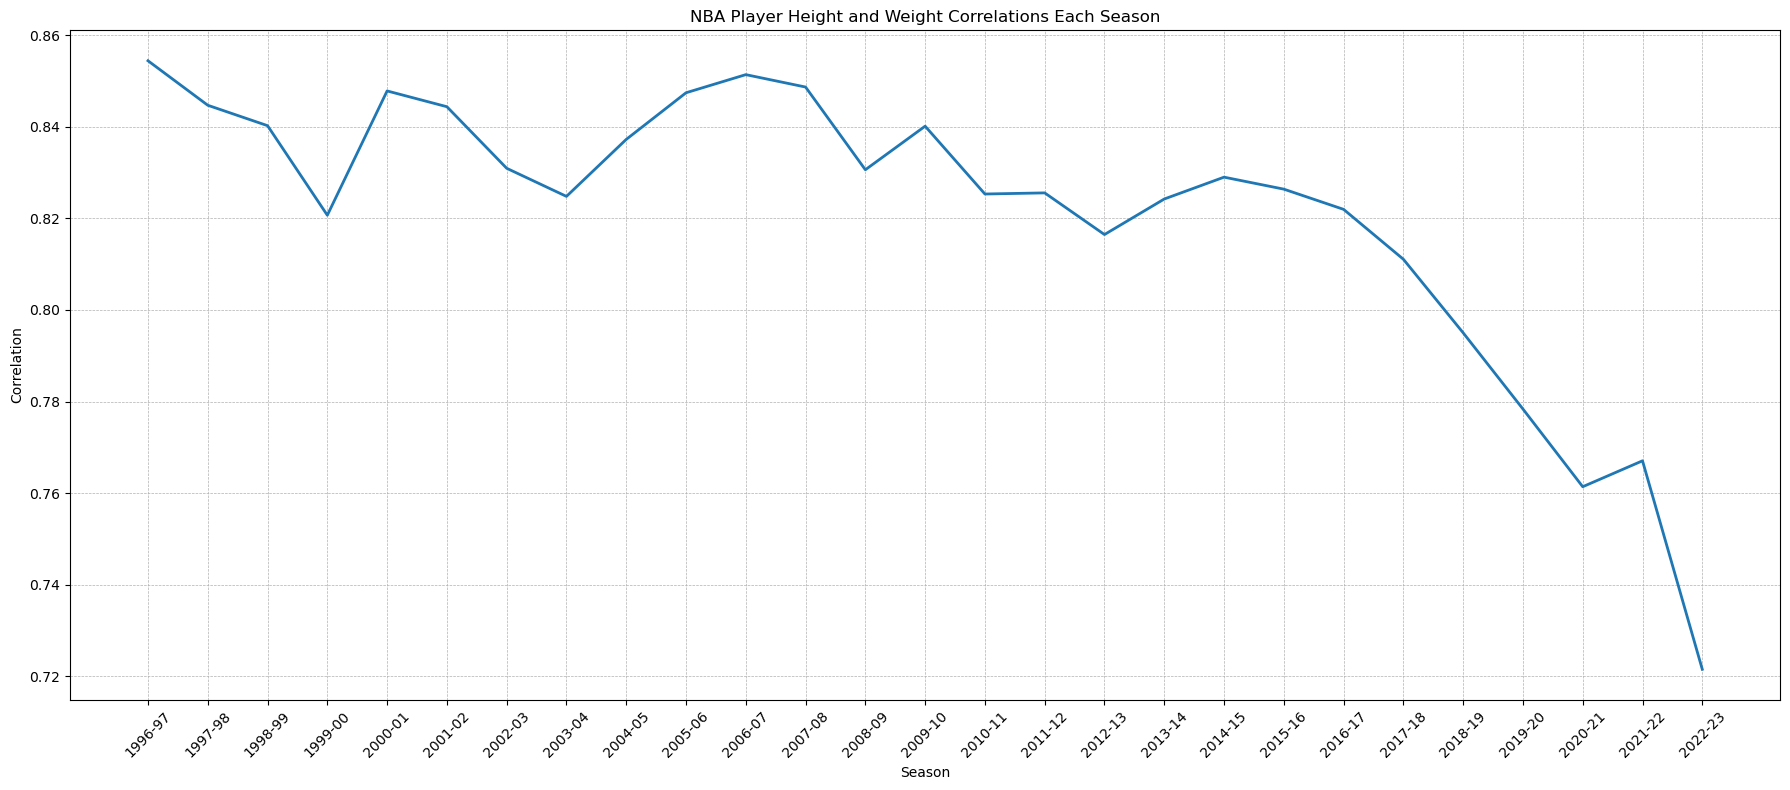

In [4]:
corr_over_seasons = nba_df.groupby('season')[['player_height', 'player_weight']].corr().unstack().iloc[:,1]

plt.figure(figsize = (18, 8))
plt.plot(corr_over_seasons.index, corr_over_seasons.values, color = 'tab:blue', linewidth = 2)

plt.title('NBA Player Height and Weight Correlations Each Season')
plt.xlabel('Season')
plt.ylabel('Correlation')

plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

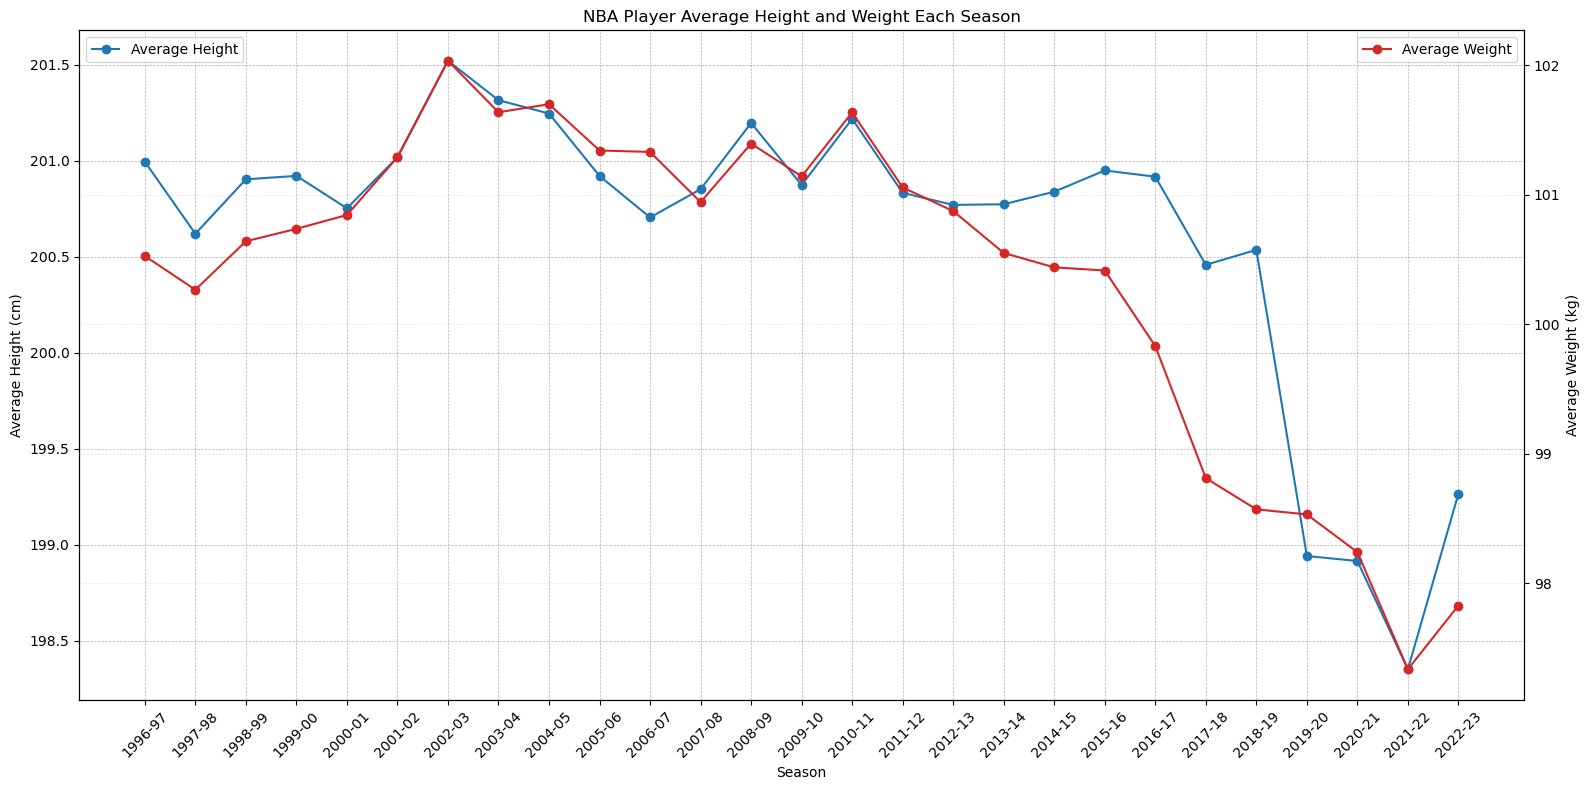

In [5]:
avg_over_seasons = nba_df.groupby('season')[['player_height', 'player_weight']].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (16, 8))

ax1.set_xlabel('Season')
ax1.set_ylabel('Average Height (cm)')
line1 = ax1.plot(avg_over_seasons['season'], avg_over_seasons['player_height'], color = 'tab:blue', marker = 'o', label = 'Average Height')
ax1.tick_params(axis = 'y')

ax1.set_xticks(avg_over_seasons['season'].index)
ax1.set_xticklabels(avg_over_seasons['season'], rotation = 45)

ax2 = ax1.twinx()
ax2.set_ylabel('Average Weight (kg)')
line2 = ax2.plot(avg_over_seasons['season'], avg_over_seasons['player_weight'], color = 'tab:red', marker = 'o', label = 'Average Weight')
ax2.tick_params(axis = 'y')

plt.title('NBA Player Average Height and Weight Each Season')

ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')

ax1.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
ax2.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, alpha = 0.3)

plt.tight_layout()
plt.show()

#### Static Visualization #3

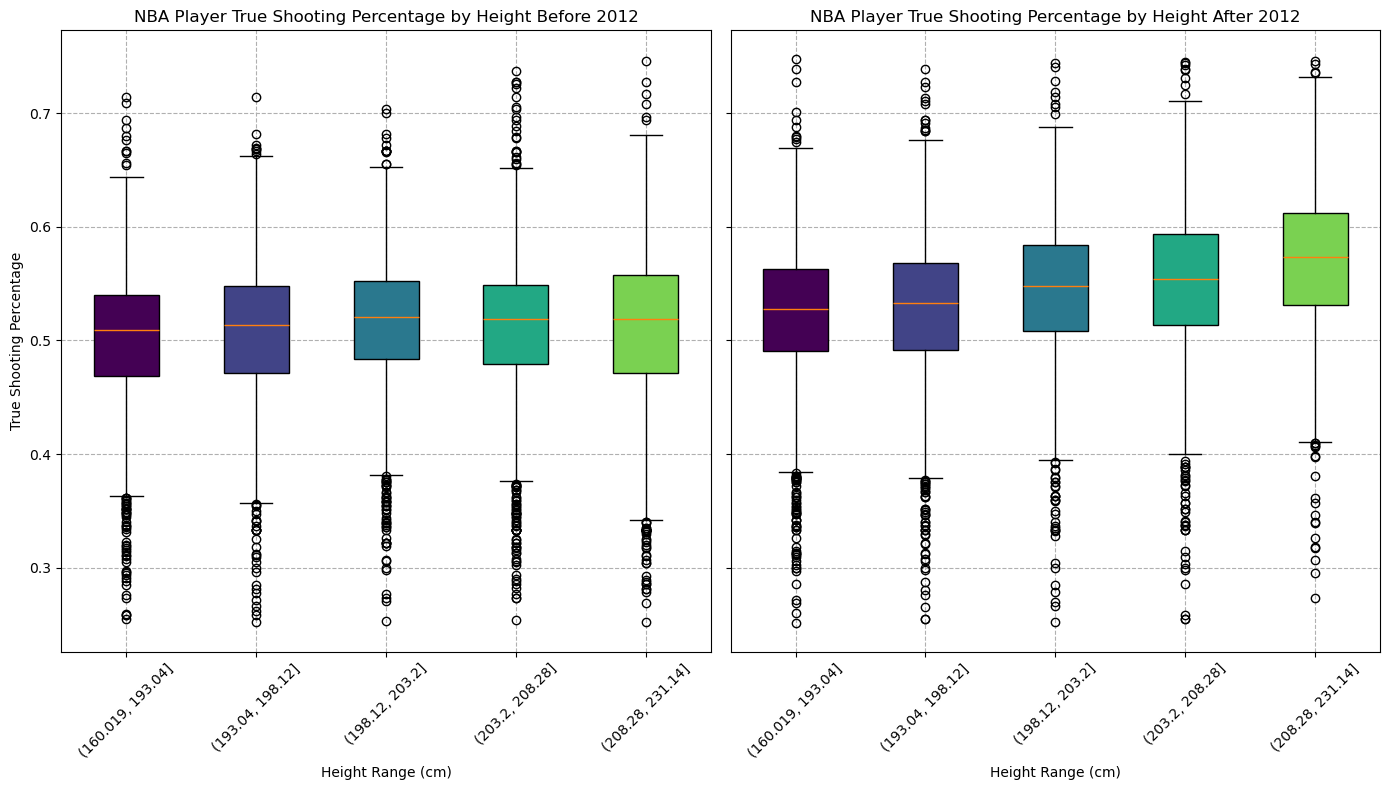

In [6]:
ts_df = nba_df[nba_df['ts_pct'] < 0.75]
ts_df = ts_df[ts_df['ts_pct'] > 0.25]

ts_df['height_bin'] = pd.qcut(ts_df['player_height'], q = 5)

ts_df['season'] = ts_df['season'].str[:4].astype(int)
data_before = ts_df[ts_df['season'] < 2012]
data_after = ts_df[ts_df['season'] > 2012]

height_bins = ts_df['height_bin'].unique()
height_bins.sort_values(inplace = True)

ts_pct_before = [data_before[data_before['height_bin'] == bin]['ts_pct'] for bin in height_bins]
ts_pct_after = [data_after[data_after['height_bin'] == bin]['ts_pct'] for bin in height_bins]

colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 0.8, len(height_bins))]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 8), sharey = True)

bp_before = axes[0].boxplot(ts_pct_before, patch_artist = True)
for patch, color in zip(bp_before['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_title('NBA Player True Shooting Percentage by Height Before 2012')
axes[0].set_xlabel('Height Range (cm)')
axes[0].set_ylabel('True Shooting Percentage')

bp_after = axes[1].boxplot(ts_pct_after, patch_artist = True)
for patch, color in zip(bp_after['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_title('NBA Player True Shooting Percentage by Height After 2012')
axes[1].set_xlabel('Height Range (cm)')

axes[0].set_xticklabels([str(bin) for bin in height_bins], rotation = 45)
axes[1].set_xticklabels([str(bin) for bin in height_bins], rotation = 45)

axes[0].grid(True, linestyle = '--')
axes[1].grid(True, linestyle = '--')

plt.tight_layout()
plt.show()

#### Static Visulization #4

In [7]:
df_corr = nba_df[['player_height', 'player_weight', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']]

corr_matrix = df_corr.corr()
corr_matrix

player_height  player_weight        gp       pts       reb  \
player_height       1.000000       0.822141  0.004963 -0.055284  0.424220   
player_weight       0.822141       1.000000  0.022828 -0.025023  0.438112   
gp                  0.004963       0.022828  1.000000  0.536003  0.471405   
pts                -0.055284      -0.025023  0.536003  1.000000  0.624509   
reb                 0.424220       0.438112  0.471405  0.624509  1.000000   
ast                -0.442781      -0.371675  0.382726  0.664320  0.247841   
net_rating         -0.003074       0.003547  0.248412  0.215199  0.187820   
oreb_pct            0.589538       0.599511 -0.014763 -0.125164  0.407960   
dreb_pct            0.614273       0.605639  0.067911  0.055669  0.611899   
usg_pct            -0.104011      -0.065811  0.147248  0.641469  0.232968   
ts_pct              0.076797       0.070992  0.367876  0.373439  0.313451   
ast_pct            -0.608696      -0.521939  0.131720  0.337339 -0.062654   

                    ast  net_rating  oreb_pct  dreb_pct   usg_pct    ts_pct  \
player_height -0.442781   -0.003074  0.589538  0.614273 -0.104011  0.076797   
player_weight -0.371675    0.003547  0.599511  0.605639 -0.065811  0.070992   
gp             0.382726    0.248412 -0.014763  0.067911  0.147248  0.367876   
pts            0.664320    0.215199 -0.125164  0.055669  0.641469  0.373439   
reb            0.247841    0.187820  0.407960  0.611899  0.232968  0.313451   
ast            1.000000    0.162865 -0.337970 -0.192146  0.396505  0.174494   
net_rating     0.162865    1.000000  0.055761  0.047928  0.026575  0.313251   
oreb_pct      -0.337970    0.055761  1.000000  0.555358 -0.100091  0.060572   
dreb_pct      -0.192146    0.047928  0.555358  1.000000 -0.007402  0.105150   
usg_pct        0.396505    0.026575 -0.100091 -0.007402  1.000000  0.119323   
ts_pct         0.174494    0.313251  0.060572  0.105150  0.119323  1.000000   
ast_pct        0.803150    0.063809 -0.424056 -0.317477  0.339286  0.022195   

                ast_pct  
player_height -0.608696  
player_weight -0.521939  
gp             0.131720  
pts            0.337339  
reb           -0.062654  
ast            0.803150  
net_rating     0.063809  
oreb_pct      -0.424056  
dreb_pct      -0.317477  
usg_pct        0.339286  
ts_pct         0.022195  
ast_pct        1.000000

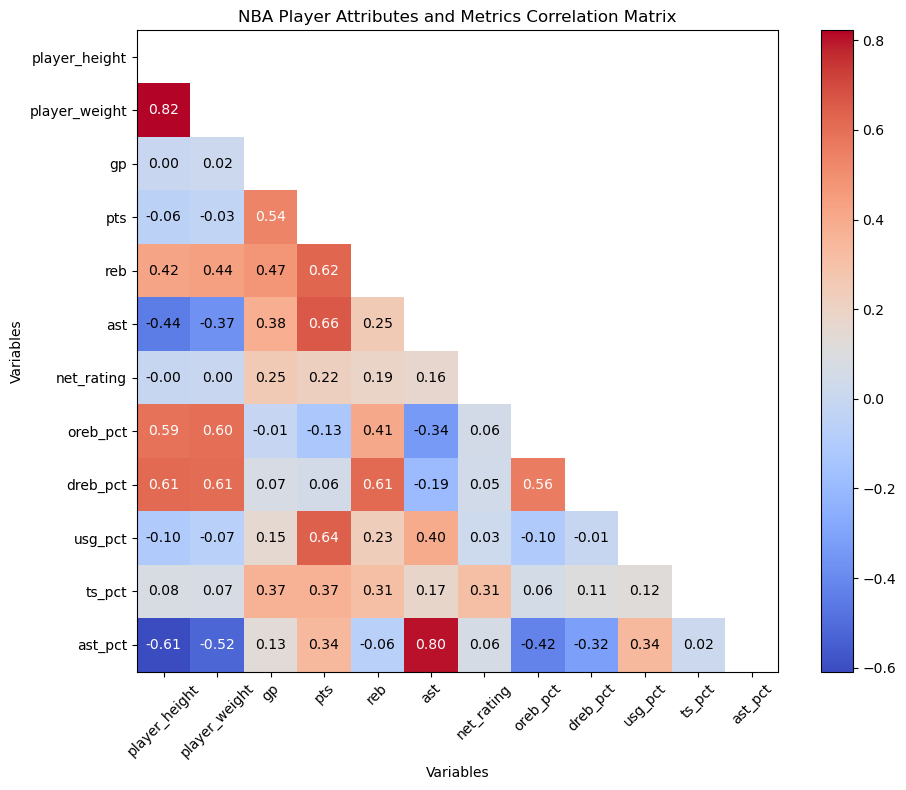

In [8]:
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
masked_corr_matrix = corr_matrix.where(~mask)

fig, ax = plt.subplots(figsize = (10, 8))
hm = ax.matshow(masked_corr_matrix, cmap = 'coolwarm')

fig.colorbar(hm)

for (i, j), val in np.ndenumerate(corr_matrix):
    if i >= j:
        ax.text(j, i, f'{val:.2f}', ha = 'center', va = 'center', color = 'white' if abs(val) > 0.5 else 'black')

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation = 45)
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns)

ax.set_title('NBA Player Attributes and Metrics Correlation Matrix')
ax.set_xlabel('Variables')
ax.set_ylabel('Variables')

ax.xaxis.tick_bottom()

plt.tight_layout()
plt.show()

#### Interactive Visualization #1

In [9]:
corr_h_ts = nba_df.groupby('season')[['player_height', 'ts_pct']].corr().unstack().iloc[:, 1]
corr_w_ts = nba_df.groupby('season')[['player_weight', 'ts_pct']].corr().unstack().iloc[:, 1]

corr_h_ap = nba_df.groupby('season')[['player_height', 'ast_pct']].corr().unstack().iloc[:, 1]
corr_w_ap = nba_df.groupby('season')[['player_weight', 'ast_pct']].corr().unstack().iloc[:, 1]

corr_df = pd.DataFrame({
    'Season': corr_h_ts.index,
    'Height and True Shooting Percentage': corr_h_ts.values,
    'Weight and True Shooting Percentage': corr_w_ts.values,
    'Height and Assist Percentage': corr_h_ap.values,
    'Weight and Assist Percentage': corr_w_ap.values,
})

corr_df = corr_df.melt(id_vars = ['Season'], var_name = 'Metric', value_name = 'Correlation')

In [10]:
selection = alt.selection_point(fields = ['Metric'], bind = 'legend')

chart = alt.Chart(corr_df).mark_line().encode(
    x = alt.X('Season:N', axis = alt.Axis(title = 'Season', labelAngle = -45)),
    y = alt.Y('Correlation:Q', axis = alt.Axis(title = 'Correlation')),
    color = 'Metric:N',
    opacity = alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip = ['Season:N', 'Metric:N', 'Correlation:Q']
).properties(
    width = 800,
    height = 600,
    title = 'NBA Player Physical Attributes and Performance Metrics Correlations Each Season'
).add_params(
    selection
).interactive()

chart

alt.Chart(...)

#### Interactive Visualization #2

In [11]:
nba_df['country'] = nba_df['country'].replace({'Great Britain': 'United Kingdom', 'England': 'United Kingdom', 'Scotland': 'United Kingdom',
                                               'Bosnia & Herzegovina': 'Bosnia and Herzegovina', 'Bosnia': 'Bosnia and Herzegovina',
                                               'Cabo Verde': 'Cape Verde', 'St. Vincent & Grenadines': 'Saint Vincent and Grenadines', 'USA': 'United States of America'})

In [12]:
countries = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
countries.head()

featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  \
0         0      2  Sovereign country   1                         Fiji   
1         0      2  Sovereign country   1  United Republic of Tanzania   
2         0      2      Indeterminate   1               Western Sahara   
3         0      2  Sovereign country   1                       Canada   
4         1      2            Country   1     United States of America   

  ADM0_A3  GEOU_DIF                   GEOUNIT GU_A3  SU_DIF         SUBUNIT  \
0     FJI         0                      Fiji   FJI       0            Fiji   
1     TZA         0                  Tanzania   TZA       0        Tanzania   
2     SAH         0            Western Sahara   SAH       0  Western Sahara   
3     CAN         0                    Canada   CAN       0          Canada   
4     USA         0  United States of America   USA       0   United States   

  SU_A3  BRK_DIFF                      NAME       NAME_LONG BRK_A3  \
0   FJI         0                      Fiji            Fiji    FJI   
1   TZA         0                  Tanzania        Tanzania    TZA   
2   SAH         1                 W. Sahara  Western Sahara    B28   
3   CAN         0                    Canada          Canada    CAN   
4   USA         0  United States of America   United States    USA   

        BRK_NAME BRK_GROUP   ABBREV POSTAL                         FORMAL_EN  \
0           Fiji      None     Fiji     FJ                  Republic of Fiji   
1       Tanzania      None    Tanz.     TZ       United Republic of Tanzania   
2      W. Sahara      None  W. Sah.     WS  Sahrawi Arab Democratic Republic   
3         Canada      None     Can.     CA                            Canada   
4  United States      None   U.S.A.     US          United States of America   

  FORMAL_FR      NAME_CIAWF NOTE_ADM0                         NOTE_BRK  \
0      None            Fiji      None                             None   
1      None        Tanzania      None                             None   
2      None  Western Sahara      None  Self admin.; Claimed by Morocco   
3      None          Canada      None                             None   
4      None   United States      None                             None   

                  NAME_SORT NAME_ALT  MAPCOLOR7  MAPCOLOR8  MAPCOLOR9  \
0                      Fiji     None          5          1          2   
1                  Tanzania     None          3          6          2   
2            Western Sahara     None          4          7          4   
3                    Canada     None          6          6          2   
4  United States of America     None          4          5          1   

   MAPCOLOR13      POP_EST  POP_RANK  POP_YEAR    GDP_MD  GDP_YEAR  \
0           2     889953.0        11      2019      5496      2019   
1           2   58005463.0        16      2019     63177      2019   
2           4     603253.0        11      2017       907      2007   
3           2   37589262.0        15      2019   1736425      2019   
4           1  328239523.0        17      2019  21433226      2019   

                     ECONOMY              INCOME_GRP FIPS_10 ISO_A2 ISO_A2_EH  \
0       6. Developing region  4. Lower middle income      FJ     FJ        FJ   
1  7. Least developed region           5. Low income      TZ     TZ        TZ   
2  7. Least developed region           5. Low income      WI     EH        EH   
3    1. Developed region: G7    1. High income: OECD      CA     CA        C

In [13]:
relevant_fields = nba_df[['player_name', 'player_height', 'player_weight', 'country', 'season']]
player_first_season = relevant_fields.loc[relevant_fields.groupby(['player_name']).season.idxmin()]

nba_df_geography = player_first_season.groupby('country', as_index = False).agg(
                                                                            {'player_height': 'mean', 'player_weight': 'mean', 'player_name': 'count'}
                                                                            ).rename({'player_name': 'count'}, axis = 1)

nba_df_geography = nba_df_geography[nba_df_geography['count'] >= 3]

In [14]:
nba_df_geography = pd.merge(countries, nba_df_geography, 'outer', left_on = 'NAME', right_on = 'country')

height_map = nba_df_geography
weight_map = nba_df_geography

nba_df_geography.head()

featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country        1.0        6.0                         Fiji    FJI   
1  Admin-0 country        1.0        3.0  United Republic of Tanzania    TZA   
2  Admin-0 country        1.0        7.0               Western Sahara    SAH   
3  Admin-0 country        1.0        2.0                       Canada    CAN   
4  Admin-0 country        1.0        2.0     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  \
0       0.0    2.0  Sovereign country   1                         Fiji   
1       0.0    2.0  Sovereign country   1  United Republic of Tanzania   
2       0.0    2.0      Indeterminate   1               Western Sahara   
3       0.0    2.0  Sovereign country   1                       Canada   
4       1.0    2.0            Country   1     United States of America   

  ADM0_A3  GEOU_DIF                   GEOUNIT GU_A3  SU_DIF         SUBUNIT  \
0     FJI       0.0                      Fiji   FJI     0.0            Fiji   
1     TZA       0.0                  Tanzania   TZA     0.0        Tanzania   
2     SAH       0.0            Western Sahara   SAH     0.0  Western Sahara   
3     CAN       0.0                    Canada   CAN     0.0          Canada   
4     USA       0.0  United States of America   USA     0.0   United States   

  SU_A3  BRK_DIFF                      NAME       NAME_LONG BRK_A3  \
0   FJI       0.0                      Fiji            Fiji    FJI   
1   TZA       0.0                  Tanzania        Tanzania    TZA   
2   SAH       1.0                 W. Sahara  Western Sahara    B28   
3   CAN       0.0                    Canada          Canada    CAN   
4   USA       0.0  United States of America   United States    USA   

        BRK_NAME BRK_GROUP   ABBREV POSTAL                         FORMAL_EN  \
0           Fiji      None     Fiji     FJ                  Republic of Fiji   
1       Tanzania      None    Tanz.     TZ       United Republic of Tanzania   
2      W. Sahara      None  W. Sah.     WS  Sahrawi Arab Democratic Republic   
3         Canada      None     Can.     CA                            Canada   
4  United States      None   U.S.A.     US          United States of America   

  FORMAL_FR      NAME_CIAWF NOTE_ADM0                         NOTE_BRK  \
0      None            Fiji      None                             None   
1      None        Tanzania      None                             None   
2      None  Western Sahara      None  Self admin.; Claimed by Morocco   
3      None          Canada      None                             None   
4      None   United States      None                             None   

                  NAME_SORT NAME_ALT  MAPCOLOR7  MAPCOLOR8  MAPCOLOR9  \
0                      Fiji     None        5.0        1.0        2.0   
1                  Tanzania     None        3.0        6.0        2.0   
2            Western Sahara     None        4.0        7.0        4.0   
3                    Canada     None        6.0        6.0        2.0   
4  United States of America     None        4.0        5.0        1.0   

   MAPCOLOR13      POP_EST  POP_RANK  POP_YEAR      GDP_MD  GDP_YEAR  \
0         2.0     889953.0      11.0    2019.0      5496.0    2019.0   
1         2.0   58005463.0      16.0    2019.0     63177.0    2019.0   
2         4.0     603253.0      11.0    2017.0       907.0    2007.0   
3         2.0   37589262.0      15.0    2019.0   1736425.0    2019.0   
4         1.0  328239523.0      17.0    2019.0  21433226.0    2019.0   

                     ECONOMY              INCOME_GRP FIPS_10 ISO_A2 ISO_A2_EH  \
0       6. Developing region  4. Lower middle income      FJ     FJ        FJ   
1  7. Least developed region           5. Low income      TZ     TZ        TZ   
2  7. Least developed region           5. Low income      WI     EH        EH   
3    1. Developed region: G7    1. High income: OECD      CA    

In [15]:
m = height_map.explore(
    column = 'player_height',
    tooltip = ['NAME', 'player_height'],
    name = 'Average NBA Player Height by Country',
    missing_kwds = {'color': 'lightgrey'},
    cmap = 'Reds'
)

weight_map.explore(
    m = m,
    column = 'player_weight',
    tooltip = ['NAME', 'player_weight'],
    name = 'Average NBA Player Weight by Country',
    missing_kwds = {'color': 'lightgrey'},
    cmap = 'Blues'
)

folium.LayerControl().add_to(m)

m